# Brain Cancer Classification implementation using different CNN models

In [ ]:
from google.colab import files
from zipfile import ZipFile
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import random
import math
from tensorflow.keras.models import load_model
import seaborn as sns
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'User uploaded file {fn} width length {len(uploaded[fn])} bytes')
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file kaggle.json width length 67 bytes


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 133M/149M [00:00<00:00, 167MB/s]
100% 149M/149M [00:00<00:00, 161MB/s]


In [ ]:
file_name = '/content/brain-tumor-mri-dataset.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
input_dir = '/content/Training'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

## Creating data array with X parameters and labels array with y

In [ ]:
data = []
labels = []

In [ ]:
for cat_id, category in enumerate(categories):
  for file in os.listdir(os.path.join(input_dir, category)):
    img_path = os.path.join(input_dir, category, file)
    img = imread(img_path)
    img = resize(img, (128,128,3))
    data.append(img)
    labels.append(cat_id)

In [ ]:
data = np.array(data)
labels = np.array(labels)

## Splitting into training and testing sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, shuffle=True, stratify=labels)

### We need to check the class distribution as a preprocessing step to ensure balanced set

In [ ]:
class_distr = Counter(y_train)

In [ ]:
class_distr

Counter({0: 991, 2: 1196, 3: 1093, 1: 1004})

In [ ]:
def visualize_distribution(distr):
  labels = distr.keys()
  sizes = distr.values()
  plt.figure(figsize=(8, 6))
  plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
  plt.title('Class Distribution')
  plt.show()

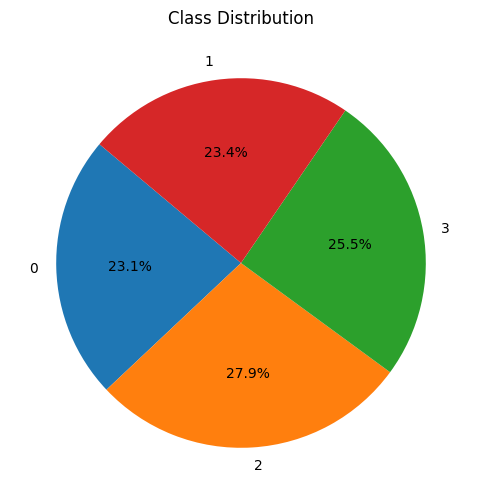

In [ ]:
visualize_distribution(class_distr)

### Since the classes are unequally distributed, we need to augment the data by generating extra images to balance out the set

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
def augment_data(x_train, y_train, class_distribution):
    max_samples = max(class_distribution.values())
    new_x, new_y = [], []

    for class_label in class_distribution:
        class_indices = np.where(y_train == class_label)[0]
        class_samples = x_train[class_indices]
        class_count = class_distribution[class_label]


        num_augmented_samples = max_samples - class_count


        if num_augmented_samples > 0:
            aug_iter = datagen.flow(class_samples, batch_size=1)
            for _ in range(num_augmented_samples):
                augmented_image = next(aug_iter)[0].astype(np.uint8)
                new_x.append(augmented_image)
                new_y.append(class_label)

    new_x = np.array(new_x)
    new_y = np.array(new_y)


    x_train_balanced = np.concatenate((x_train, new_x), axis=0)
    y_train_balanced = np.concatenate((y_train, new_y), axis=0)

    return x_train_balanced, y_train_balanced

In [ ]:
X_train_balanced, y_train_balanced = augment_data(X_train, y_train, class_distr)

In [ ]:
class_distr_balanced = Counter(y_train_balanced)

In [ ]:
class_distr_balanced

Counter({0: 1196, 2: 1196, 3: 1196, 1: 1196})

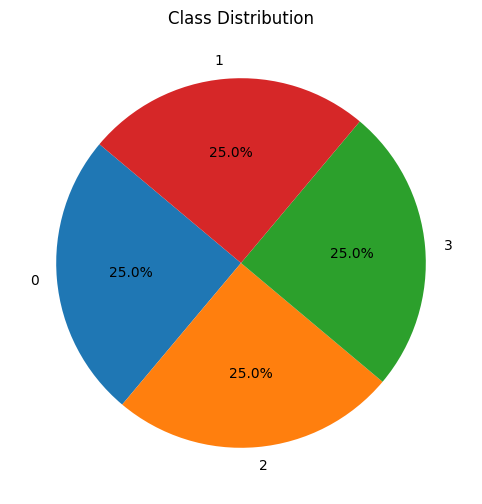

In [ ]:
visualize_distribution(class_distr_balanced)

### As shown above, the classes were balanced out

## Normalizing training and testing sets

In [ ]:
X_train_balanced = X_train_balanced/255
X_val = X_val/255

### We will utilize the keras tuner to find the best set of hyperparameters for each model

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

### First architecture starts with 3 convolutional layers with units ranging from 16 to 256, and 2 dense layers with units ranging from 16 to 256 for the first layer and 4 for the last as it is the output layer that needs to classify 4 classes

In [ ]:
def create_model(hp):
  hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=256, step=1)
  hp_filters_2 = hp.Int('filters_2', min_value=16, max_value=256, step=1)
  hp_filters_3 = hp.Int('filters_3', min_value=16, max_value=256, step=1)
  hp_nodes_1 = hp.Int('nodes_1', min_value=32, max_value=256, step=1)
  hp_dr_1 = hp.Choice('dr_1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  model = Sequential()
  model.add(Conv2D(hp_filters_1, (3,3), activation='tanh', input_shape=X_train_balanced[0].shape))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_2, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_3, (3,3), activation='tanh'))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(hp_nodes_1, activation='tanh'))
  model.add(Dropout(hp_dr_1))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(hp_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

### Second architecture is increased in density and in unit range. 2 additional convolutional layers were added and the range was increased to 500. The number of dense layers was increased to 4 including the output layer. The range of the dense layer units was increased to 1000, except, of course, for the output layer

In [ ]:
def create_model1(hp):
  hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=500, step=1)
  hp_filters_2 = hp.Int('filters_2', min_value=16, max_value=500, step=1)
  hp_filters_3 = hp.Int('filters_3', min_value=16, max_value=500, step=1)
  hp_filters_4 = hp.Int('filters_4', min_value=16, max_value=500, step=1)
  hp_filters_5 = hp.Int('filters_5', min_value=16, max_value=500, step=1)
  hp_nodes_1 = hp.Int('nodes_1', min_value=32, max_value=1000, step=1)
  hp_nodes_2 = hp.Int('nodes_2', min_value=32, max_value=1000, step=1)
  hp_nodes_3 = hp.Int('nodes_3', min_value=32, max_value=1000, step=1)
  hp_dr_1 = hp.Choice('dr_1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  model = Sequential()
  model.add(Conv2D(hp_filters_1, (3,3), activation='tanh', input_shape=X_train_balanced[0].shape))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_2, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_3, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_4, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_5, (3,3), activation='tanh'))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(hp_nodes_1, activation='tanh'))
  model.add(Dropout(hp_dr_1))
  model.add(Dense(hp_nodes_2, activation='tanh'))
  model.add(Dropout(hp_dr_1))
  model.add(Dense(hp_nodes_3, activation='tanh'))
  model.add(Dropout(hp_dr_1))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(hp_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

### Third architecture increases the number of convolutional layers by 1 and decreases the number of dense layers to 2

In [ ]:
def create_model2(hp):
  hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=500, step=1)
  hp_filters_2 = hp.Int('filters_2', min_value=16, max_value=500, step=1)
  hp_filters_3 = hp.Int('filters_3', min_value=16, max_value=500, step=1)
  hp_filters_4 = hp.Int('filters_4', min_value=16, max_value=500, step=1)
  hp_filters_5 = hp.Int('filters_5', min_value=16, max_value=500, step=1)
  hp_filters_6 = hp.Int('filters_6', min_value=16, max_value=500, step=1)

  hp_nodes_1 = hp.Int('nodes_1', min_value=32, max_value=1000, step=1)

  hp_dr_1 = hp.Choice('dr_1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  model = Sequential()

  model.add(Conv2D(hp_filters_1, (3,3), activation='tanh', input_shape=X_train_balanced[0].shape))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_2, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_4, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_5, (3,3), activation='tanh'))
  model.add(MaxPooling2D())
  model.add(Conv2D(hp_filters_6, (3,3), activation='tanh'))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(hp_nodes_1, activation='tanh'))
  model.add(Dropout(hp_dr_1))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(hp_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

## Function to visualize the learning curve

In [ ]:
def plot_loss(history, number):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel(f'Sparse categorical crossentropy')
    plt.legend()
    plt.title(f'Val Loss for model {number}')
    plt.grid(True)
    plt.show()

def plot_accuracy(history, number):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel(f'Accuracy for model')
    plt.title(f'Accuracy for model {number}')
    plt.legend()
    plt.grid(True)
    plt.show()

## 3 tuners are initialized corresponding to 3 architectures that will look for the best set of hyper parameters within the first 10 epochs


In [ ]:
tuner = kt.Hyperband(create_model, objective='val_accuracy', max_epochs=10, factor=3, directory='dir', project_name='x')

In [ ]:
tuner1 = kt.Hyperband(create_model1, objective='val_accuracy', max_epochs=10, factor=3, directory='dir2', project_name='x1')

In [ ]:
tuner2 = kt.Hyperband(create_model2, objective='val_accuracy', max_epochs=10, factor=3, directory='dir3', project_name='x2')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 30 Complete [00h 02m 26s]
val_accuracy: 0.8543417453765869

Best val_accuracy So Far: 0.918067216873169
Total elapsed time: 00h 26m 06s


In [ ]:
tuner1.search(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 30 Complete [00h 03m 27s]
val_accuracy: 0.8690476417541504

Best val_accuracy So Far: 0.9271708726882935
Total elapsed time: 00h 55m 20s


In [ ]:
tuner2.search(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 30 Complete [00h 05m 35s]
val_accuracy: 0.9173669219017029

Best val_accuracy So Far: 0.9320728182792664
Total elapsed time: 00h 49m 33s


### Extracting best hyperparameters of the tuners and building models off of them

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

## Functions to plot the model performance shown by confusion matrix and classification report

In [ ]:
def visualize_cm(cm, y_true):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def plot_cr(cr):
  report_df = pd.DataFrame(cr).transpose()
  plt.figure(figsize=(10, 6))
  sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
  plt.title('Classification Report')
  plt.show()

Epoch 1/50
150/150 [==============================] - 15s 92ms/step - loss: 1.0474 - accuracy: 0.5414 - val_loss: 0.5814 - val_accuracy: 0.8137
Epoch 2/50
150/150 [==============================] - 13s 85ms/step - loss: 0.6374 - accuracy: 0.7362 - val_loss: 0.7865 - val_accuracy: 0.6681
Epoch 3/50
150/150 [==============================] - 13s 85ms/step - loss: 0.5121 - accuracy: 0.7906 - val_loss: 0.4225 - val_accuracy: 0.8550
Epoch 4/50
150/150 [==============================] - 13s 86ms/step - loss: 0.4204 - accuracy: 0.8192 - val_loss: 0.3480 - val_accuracy: 0.8782
Epoch 5/50
150/150 [==============================] - 13s 87ms/step - loss: 0.3145 - accuracy: 0.8658 - val_loss: 0.3020 - val_accuracy: 0.8971
Epoch 6/50
150/150 [==============================] - 13s 86ms/step - loss: 0.2432 - accuracy: 0.8930 - val_loss: 0.3105 - val_accuracy: 0.8971
Epoch 7/50
150/150 [==============================] - 13s 86ms/step - loss: 0.2161 - accuracy: 0.9091 - val_loss: 0.3096 - val_accuracy:

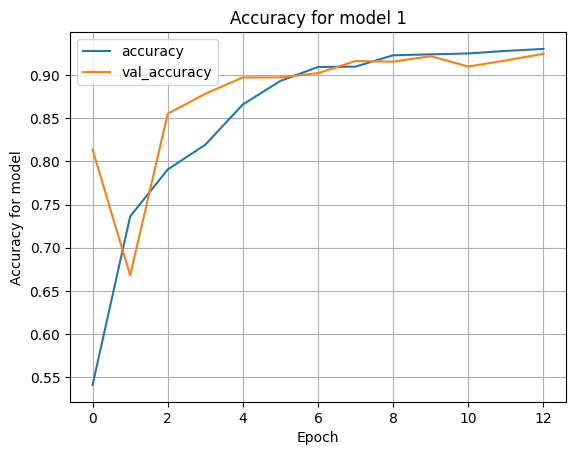

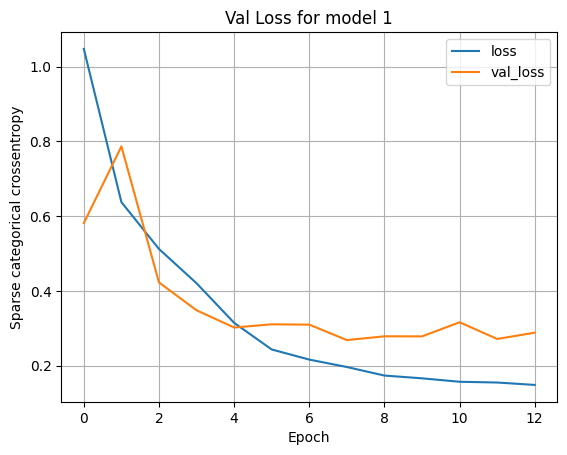

In [ ]:
history = model.fit(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])
plot_accuracy(history, 1)
plot_loss(history, 1)

In [ ]:
best_hps1 = tuner1.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model1 = tuner1.hypermodel.build(best_hps1)

Epoch 1/50
150/150 [==============================] - 31s 190ms/step - loss: 1.1331 - accuracy: 0.4990 - val_loss: 0.8479 - val_accuracy: 0.6905
Epoch 2/50
150/150 [==============================] - 28s 188ms/step - loss: 0.8322 - accuracy: 0.6645 - val_loss: 0.5865 - val_accuracy: 0.7738
Epoch 3/50
150/150 [==============================] - 31s 208ms/step - loss: 0.6394 - accuracy: 0.7496 - val_loss: 0.5553 - val_accuracy: 0.7710
Epoch 4/50
150/150 [==============================] - 28s 188ms/step - loss: 0.5257 - accuracy: 0.7912 - val_loss: 0.3879 - val_accuracy: 0.8536
Epoch 5/50
150/150 [==============================] - 28s 188ms/step - loss: 0.4678 - accuracy: 0.8100 - val_loss: 0.3213 - val_accuracy: 0.8789
Epoch 6/50
150/150 [==============================] - 28s 189ms/step - loss: 0.3670 - accuracy: 0.8572 - val_loss: 0.2810 - val_accuracy: 0.8915
Epoch 7/50
150/150 [==============================] - 28s 190ms/step - loss: 0.3306 - accuracy: 0.8602 - val_loss: 0.2526 - val_ac

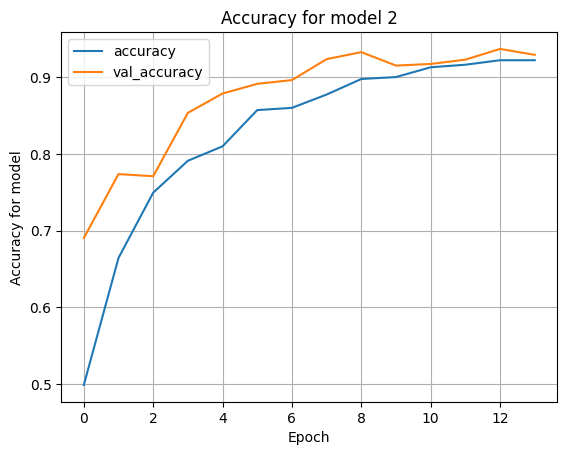

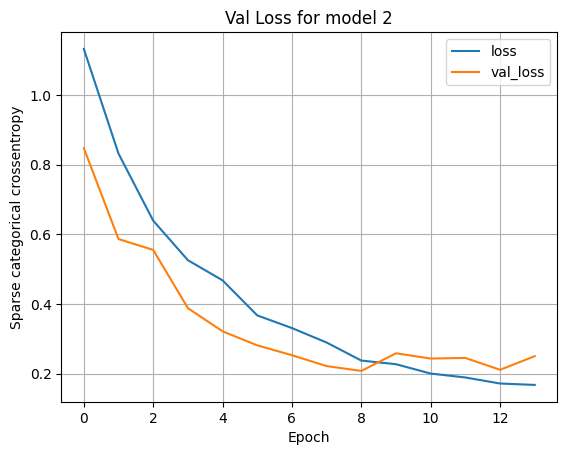

In [ ]:
history1 = model1.fit(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])
plot_accuracy(history1, 2)
plot_loss(history1, 2)

In [ ]:
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model2 = tuner2.hypermodel.build(best_hps2)

Epoch 1/50
150/150 [==============================] - 20s 106ms/step - loss: 1.2512 - accuracy: 0.4174 - val_loss: 0.9293 - val_accuracy: 0.5749
Epoch 2/50
150/150 [==============================] - 15s 97ms/step - loss: 0.7297 - accuracy: 0.7126 - val_loss: 0.4152 - val_accuracy: 0.8431
Epoch 3/50
150/150 [==============================] - 15s 98ms/step - loss: 0.5276 - accuracy: 0.7908 - val_loss: 0.3772 - val_accuracy: 0.8585
Epoch 4/50
150/150 [==============================] - 15s 98ms/step - loss: 0.3785 - accuracy: 0.8455 - val_loss: 0.3002 - val_accuracy: 0.8873
Epoch 5/50
150/150 [==============================] - 15s 99ms/step - loss: 0.3155 - accuracy: 0.8706 - val_loss: 0.3091 - val_accuracy: 0.8922
Epoch 6/50
150/150 [==============================] - 15s 99ms/step - loss: 0.2615 - accuracy: 0.8863 - val_loss: 0.2618 - val_accuracy: 0.9055
Epoch 7/50
150/150 [==============================] - 15s 101ms/step - loss: 0.2043 - accuracy: 0.9107 - val_loss: 0.2486 - val_accurac

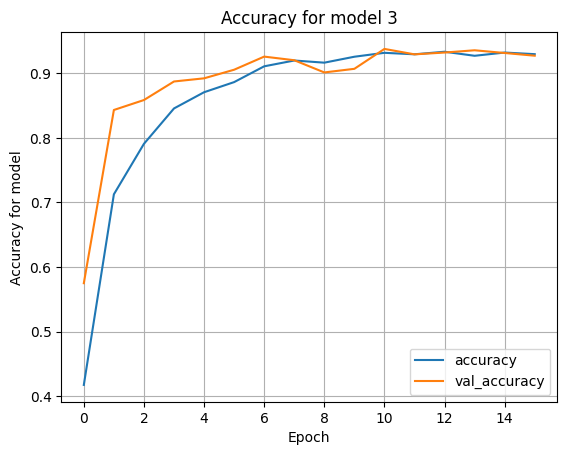

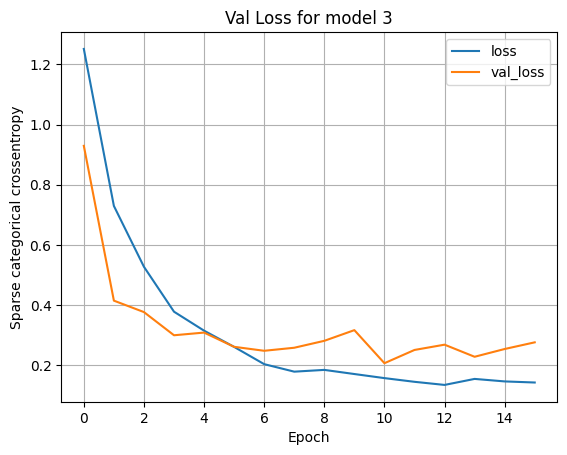

In [ ]:
history2 = model2.fit(X_train_balanced, y_train_balanced, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])
plot_accuracy(history2, 3)
plot_loss(history2, 3)

In [ ]:
model_path = '/content/drive/MyDrive/model.keras'

In [ ]:
model.save(model_path)

In [ ]:
model_path1 = '/content/drive/MyDrive/model1.keras'

In [ ]:
model1.save(model_path1)

In [ ]:
model_path2 = '/content/drive/MyDrive/model2.keras'

In [ ]:
model2.save(model_path2)

## Testing model performance

In [ ]:
input_dir_test = '/content/Testing'
categories_test = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
data_test = []
labels_test = []

In [ ]:
for cat_id, category in enumerate(categories_test):
  for file in os.listdir(os.path.join(input_dir_test, category)):
    img_path = os.path.join(input_dir_test, category, file)
    img = imread(img_path)
    img = resize(img, (128,128,3))
    data_test.append(img)
    labels_test.append(cat_id)

In [ ]:
X_test = np.array(data_test)
y_test = np.array(labels_test)

In [ ]:
X_test = X_test/255

In [ ]:
y_predict = model.predict(X_test)

41/41 [==============================] - 5s 54ms/step


In [ ]:
y_classes = [np.argmax(element) for element in y_predict]

In [ ]:
cr = classification_report(y_test, y_classes, output_dict=True)

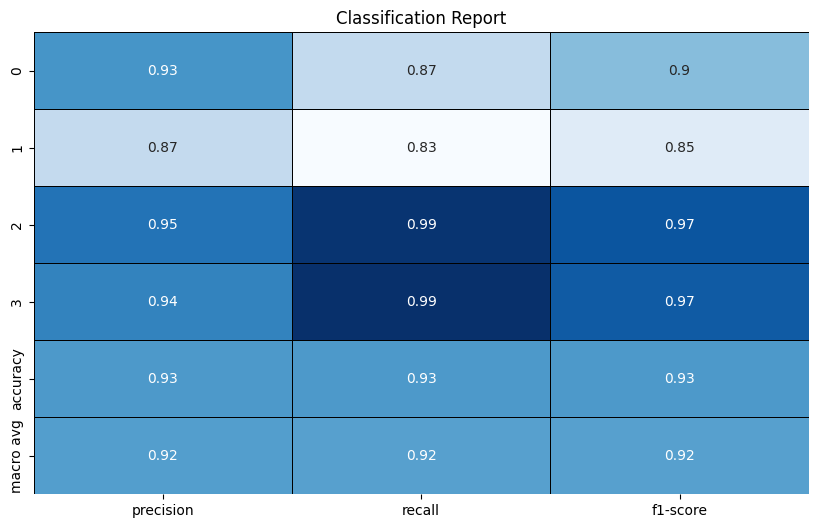

In [ ]:
plot_cr(cr)

In [ ]:
cm = confusion_matrix(y_test, y_classes)

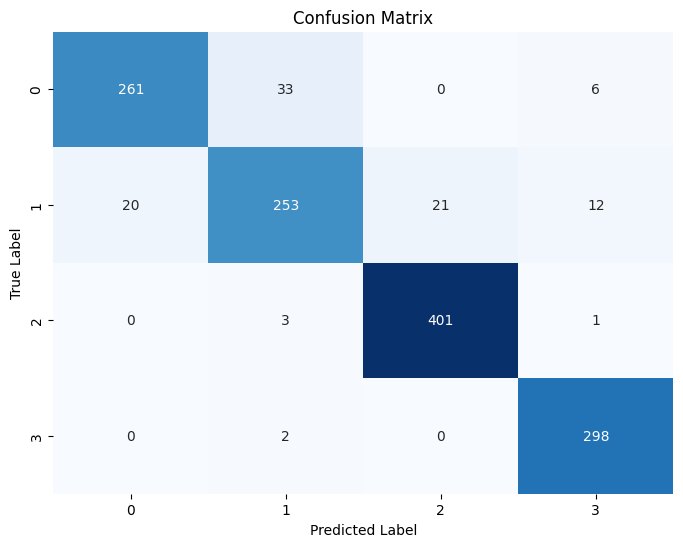

In [ ]:
visualize_cm(cm, y_test)

In [ ]:
y_predict1 = model1.predict(X_test)

41/41 [==============================] - 8s 111ms/step


In [ ]:
y_classes1 = [np.argmax(element) for element in y_predict1]

In [ ]:
cr1 = classification_report(y_test, y_classes1, output_dict=True)

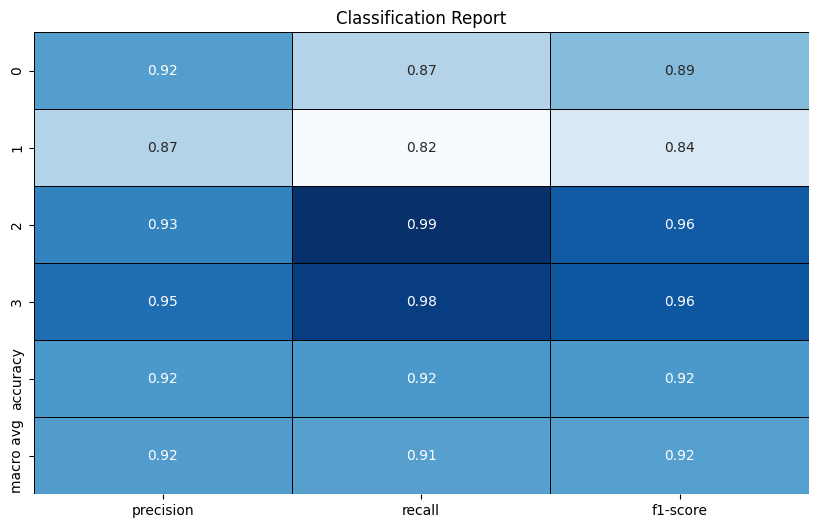

In [ ]:
plot_cr(cr1)

In [ ]:
cm1 = confusion_matrix(y_test, y_classes1)

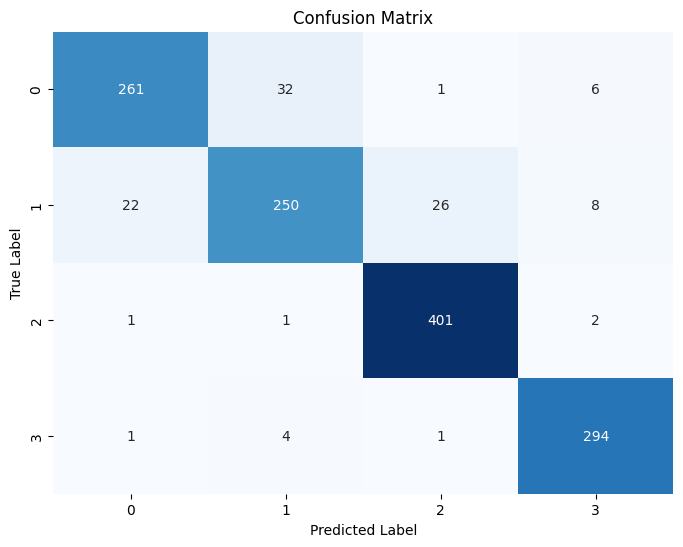

In [ ]:
visualize_cm(cm1, y_test)

In [ ]:
y_predict2 = model2.predict(X_test)

41/41 [==============================] - 5s 76ms/step


In [ ]:
y_classes2 = [np.argmax(element) for element in y_predict2]

In [ ]:
cr2 = classification_report(y_test, y_classes2, output_dict=True)

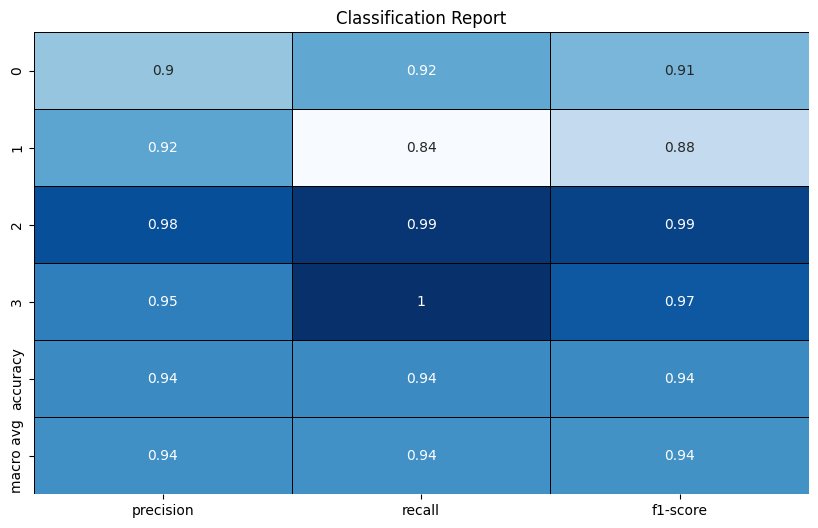

In [ ]:
plot_cr(cr2)

In [ ]:
cm2 = confusion_matrix(y_test, y_classes2)

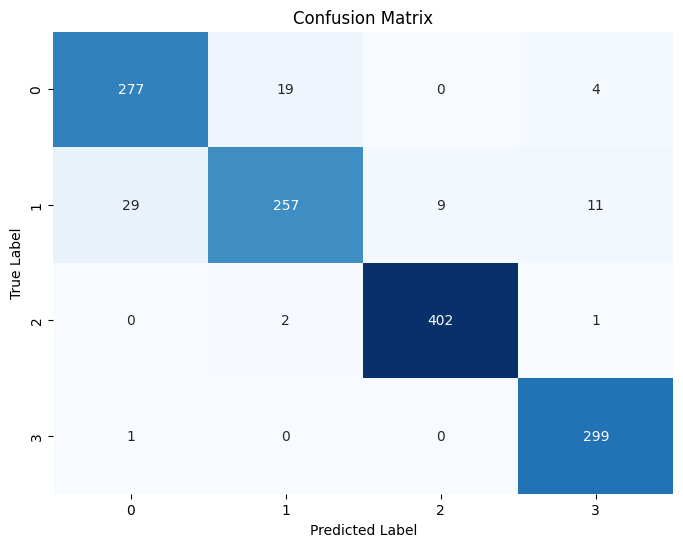

In [ ]:
visualize_cm(cm2, y_classes2)

## Function that allows to randomly pick test sample from the testing images

In [ ]:
def pick_test_sample(category, categories):
  input_dir_for_test_image = '/content/Testing/'
  files = os.listdir(os.path.join(input_dir_for_test_image, category))
  random_file = random.choice(files)
  img_path = os.path.join(input_dir_for_test_image, category, random_file)
  img = imread(img_path)
  img = resize(img, (128,128,3))
  return img, [categories.index(category)]

## Function to load the external image (image not present in the testing set, image from the external sources)

In [ ]:
def pick_external_image(path, category):
  img = imread(path)
  img = resize(img, (128,128,3))
  return img, [category]

## Function to plot against one another the true class and the predicted classes

In [ ]:
def plot_observe_predict(img, category, predict_category, categories, confidence, number):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  ax1.imshow(img)
  ax1.set_title('Observed')
  ax1.set_xlabel(categories[category])

  ax2.imshow(img)
  ax2.set_title(f'Predicted with {confidence}% confidence by model {number}')
  ax2.set_xlabel(categories[predict_category])
  plt.show()


In [ ]:
def get_confidence(y_class, y_predict):
  return math.ceil(y_predict[0][y_class]*100)

In [ ]:
def normalize_picture(img):
  normalized_picture = img/255
  normalized_picture = np.expand_dims(normalized_picture, axis=0)
  return normalized_picture

In [ ]:
test_image, category_index = pick_test_sample('pituitary', categories_test)

In [ ]:
norm_picture = normalize_picture(test_image)

In [ ]:
y_predict_test_picture = model.predict(norm_picture)

1/1 [==============================] - 0s 414ms/step


In [ ]:
y_predict_test_picture1 = model1.predict(norm_picture)

1/1 [==============================] - 1s 1s/step


In [ ]:
y_predict_test_picture2 = model2.predict(norm_picture)

1/1 [==============================] - 1s 547ms/step


In [ ]:
y_class_test_picture = [np.argmax(y_predict_test_picture)]

In [ ]:
y_class_test_picture1 = [np.argmax(y_predict_test_picture1)]

In [ ]:
y_class_test_picture2 = [np.argmax(y_predict_test_picture2)]

In [ ]:
confidence = get_confidence(y_class_test_picture, y_predict_test_picture)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


In [ ]:
confidence1 = get_confidence(y_class_test_picture1, y_predict_test_picture1)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


In [ ]:
confidence2 = get_confidence(y_class_test_picture2, y_predict_test_picture2)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


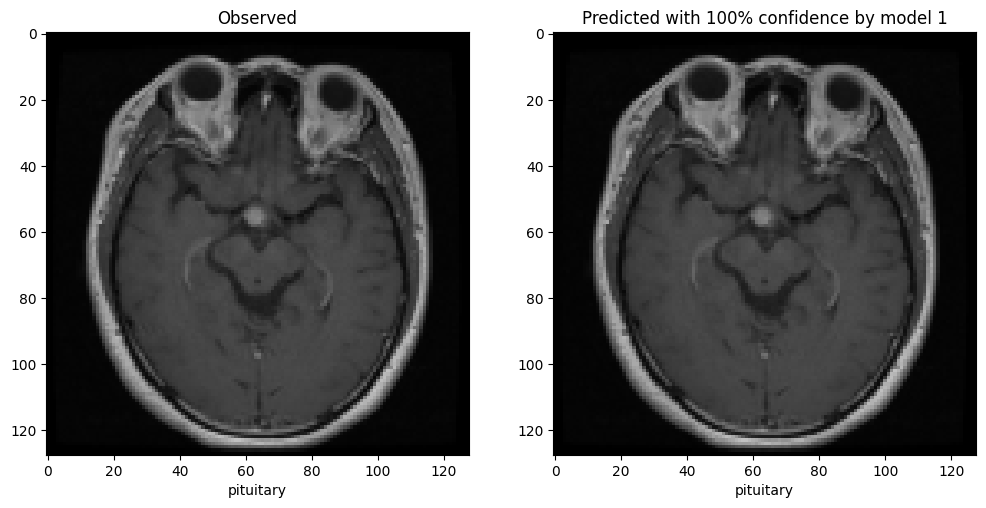

In [ ]:
plot_observe_predict(test_image, category_index[0], y_class_test_picture[0], categories_test, confidence, 1)

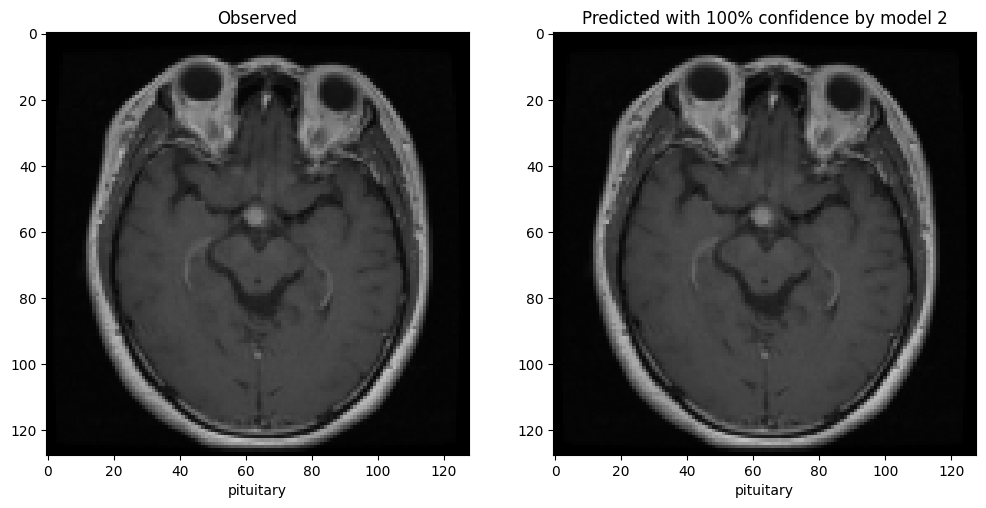

In [ ]:
plot_observe_predict(test_image, category_index[0], y_class_test_picture1[0], categories_test, confidence1, 2)

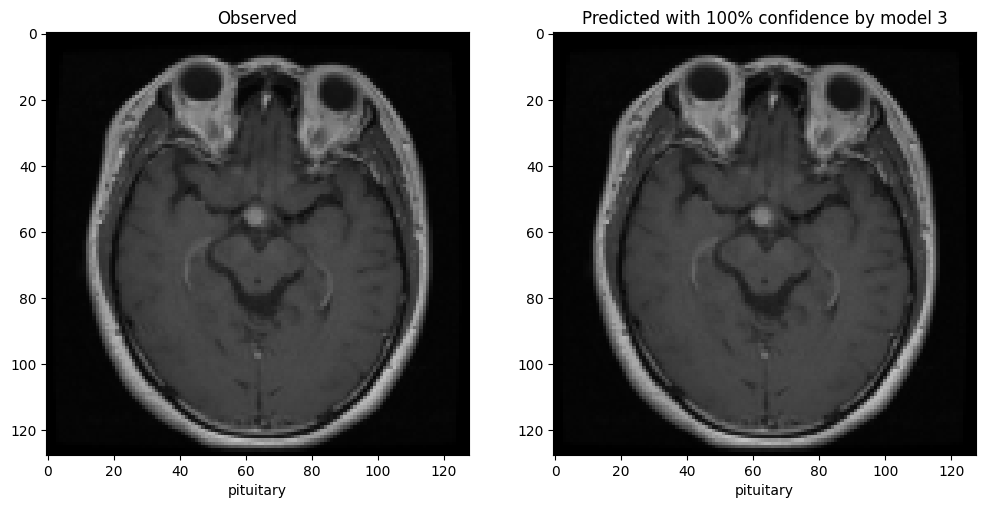

In [ ]:
plot_observe_predict(test_image, category_index[0], y_class_test_picture2[0], categories_test, confidence2, 3)

In [ ]:
external_test_pic, category_external = pick_external_image('/content/pituitary_external.jpg', 3)

In [ ]:
norm_external_test_pic = normalize_picture(external_test_pic)

In [ ]:
y_predict_external_image = model.predict(norm_external_test_pic)

1/1 [==============================] - 0s 19ms/step


In [ ]:
y_predict_external_image1 = model1.predict(norm_external_test_pic)

1/1 [==============================] - 0s 30ms/step


In [ ]:
y_predict_external_image2 = model2.predict(norm_external_test_pic)

1/1 [==============================] - 0s 17ms/step


In [ ]:
y_class_external_image = [np.argmax(y_predict_external_image)]

In [ ]:
y_class_external_image1 = [np.argmax(y_predict_external_image1)]

In [ ]:
y_class_external_image2 = [np.argmax(y_predict_external_image2)]

In [ ]:
confidence_external_image = get_confidence(y_class_external_image, y_predict_external_image)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


In [ ]:
confidence_external_image1 = get_confidence(y_class_external_image1, y_predict_external_image1)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


In [ ]:
confidence_external_image2 = get_confidence(y_class_external_image2, y_predict_external_image2)

<ipython-input-42-207866e4fb13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(y_predict[0][y_class]*100)


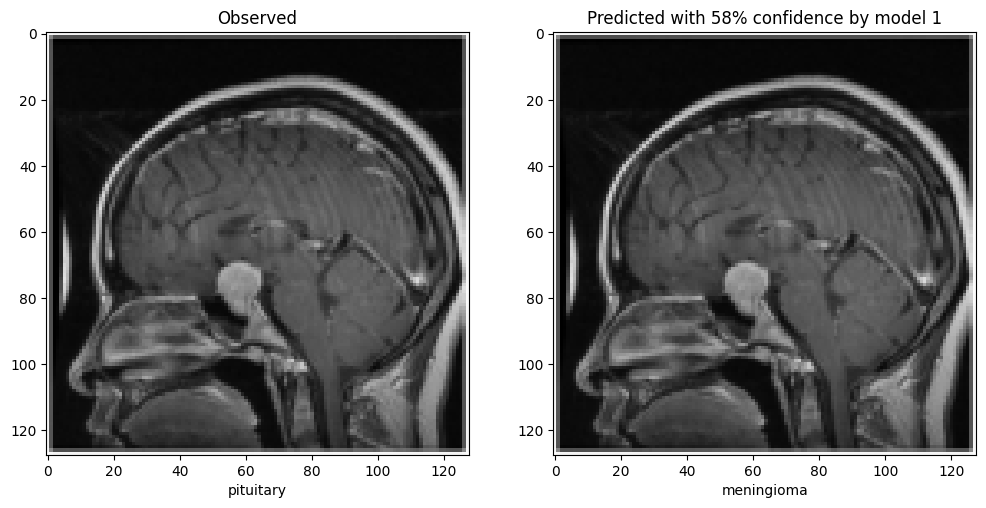

In [ ]:
plot_observe_predict(external_test_pic, category_external[0], y_class_external_image[0], categories_test, confidence_external_image, 1)

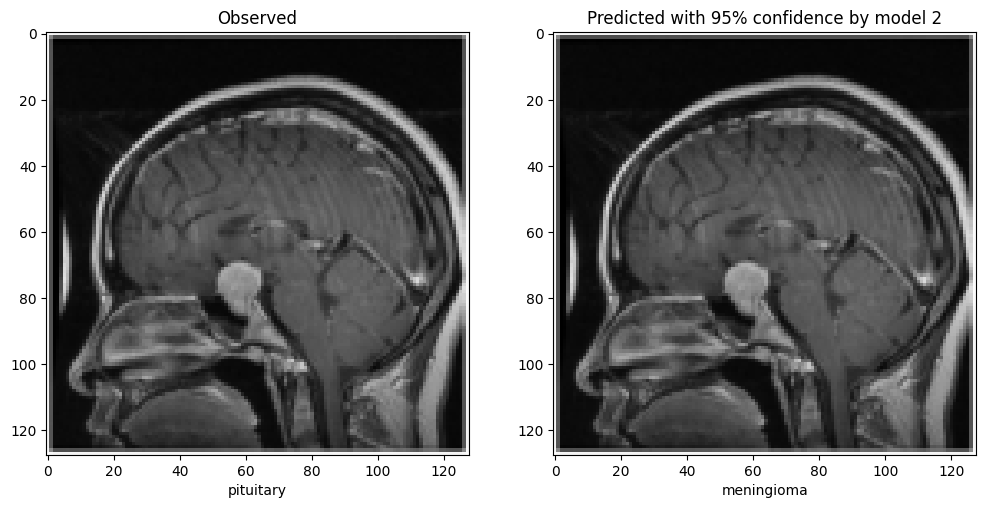

In [ ]:
plot_observe_predict(external_test_pic, category_external[0], y_class_external_image1[0], categories_test, confidence_external_image1, 2)

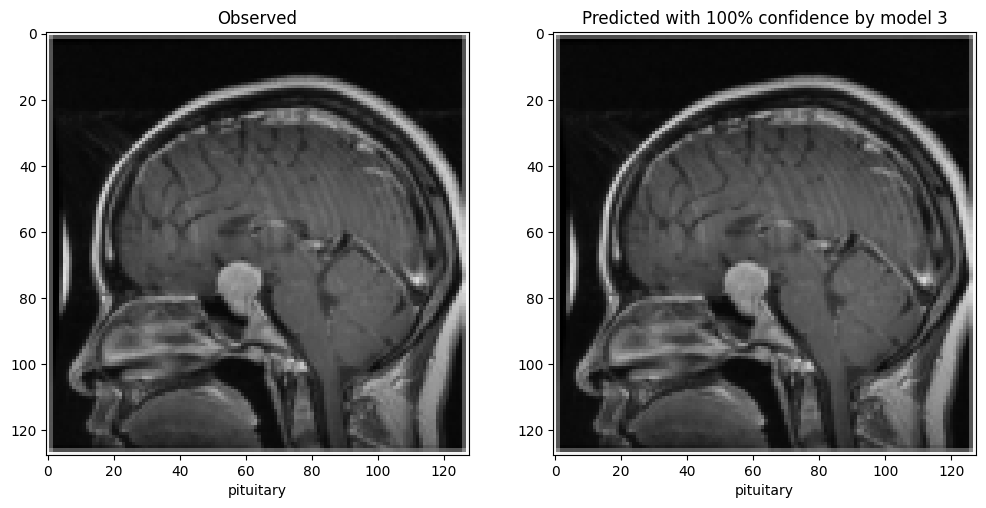

In [ ]:
plot_observe_predict(external_test_pic, category_external[0], y_class_external_image2[0], categories_test, confidence_external_image2, 3)

### As shown above, model 3 was not only superiror to the prior 2 in terms of precision, but it was also able to correctly classify an external image (taken from the internet) at a different angle whilst the previous two produced an incorrect prediction